# Fraud Detection Case

# Load Data, Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [2]:
df = pd.read_csv('raw_data/trainset_.csv')
df.head(3)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Target
0,298989cc4e92,2.615076,2311.11936,2353.415652,96.700728,150.397920,118.852344,0.745416,155.180448,55.999104,...,2.078748,8.86704,4.388904,198.690720,6812.763132,152615.473440,307.786236,1952.240592,263.736000,no_fraud
1,d02c11462079,9.024576,35279.18592,1022.401764,177.978396,97.664256,43.373664,0.306936,119.410296,14.758800,...,48.791881,24.69756,1.625520,148.013424,871.332756,70493.693472,298.632576,247.745328,1.291651,no_fraud
2,c82e5a429e5b,5.896740,33281.45172,1022.401764,165.119652,97.664256,43.905204,0.314244,169.397760,14.758800,...,28.816302,5.96472,3.494868,188.198064,1031.060310,10456.029504,450.449376,1267.214112,4.238270,no_fraud


# Basic EDA

Duplicates, missing data...

In [3]:
# Checking which columns are which dtype
print(f'Object columns: {df.select_dtypes("object").columns}')
print(f'Integer columns: {df.select_dtypes("integer").columns}')
print(f'Float columns: {df.select_dtypes("float").columns}')

Object columns: Index(['Id', 'EJ', 'Target'], dtype='object')
Integer columns: Index([], dtype='object')
Float columns: Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')


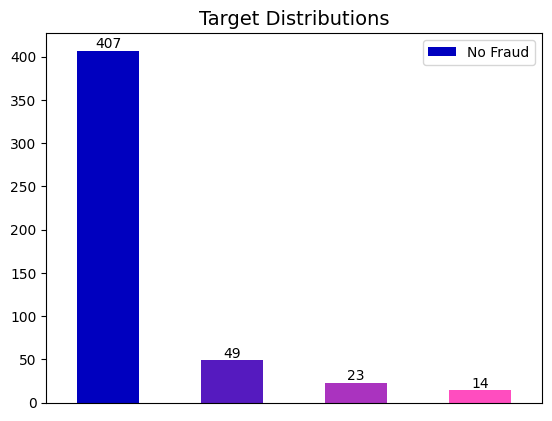

In [21]:
my_colors = [(x/3.0, x/10.0, 0.75) for x in range(len(df))]
ax = df['Target'].value_counts().plot(kind='bar', color=my_colors, xticks=[])
plt.title('Target Distributions', fontsize=14)
for n in ax.containers:
    ax.bar_label(n)
plt.legend(['No Fraud','Payment Fraud','Identification Fraud','Malware Fraud']);
# Unbalanced data set

In [22]:
# Cleaning column headers
df = df.rename(columns=lambda x: x.strip())

In [23]:
# Checking for duplicates
df.duplicated().sum()

0

__Summary__
- There are no duplicated data
- The target values are unbalanced: There are substantially more no_fraud cases vs fraud cases
- Column headings have been cleaned
- Most columns are numerical; there are 2 (excluding Id) that are objects

## Object Data - Complex version

Encoding for Target and 'EJ' columns

In [24]:
data = df.copy()

In [25]:
# Checking for NaN: Objects
data.select_dtypes('object').isnull().sum().sort_values(ascending=False)/len(data)*100

Id        0.0
EJ        0.0
Target    0.0
dtype: float64

In [26]:
data['Target'] = data['Target'].map({'no_fraud':0,
                  'payment_fraud':1,
                  'identification_fraud':2,
                  'malware_fraud':3})

data['EJ'] = data['EJ'].map({'A':0, 'B': 1})

Dropped 'Id' column

In [27]:
data.drop('Id',axis=1,inplace=True)
data.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Target
0,2.615076,2311.11936,2353.415652,96.700728,150.397920,118.852344,0.745416,155.180448,55.999104,44219.66424,...,2.078748,8.86704,4.388904,198.690720,6812.763132,152615.473440,307.786236,1952.240592,263.736000,0
1,9.024576,35279.18592,1022.401764,177.978396,97.664256,43.373664,0.306936,119.410296,14.758800,32372.92320,...,48.791881,24.69756,1.625520,148.013424,871.332756,70493.693472,298.632576,247.745328,1.291651,0


In [28]:
data['Target'].value_counts()

0    407
1     49
2     23
3     14
Name: Target, dtype: int64

__Summary__
- Created an encoded dataframe called 'data'
  - This dataframe includes the Target column with fraud cases categorised into their different subcategories

## Object Data - Simple version

Copy original df, to create targets that have either fraud or no fraud

In [29]:
simple_df = df.copy()

In [30]:
simple_df['Target'] = simple_df['Target'].map({'no_fraud':0,
                  'payment_fraud':1,
                  'identification_fraud':1,
                  'malware_fraud':1})

simple_df['EJ'] = simple_df['EJ'].map({'A':0, 'B': 1})

simple_df.drop('Id',axis=1,inplace=True)
simple_df['Target'].value_counts()

0    407
1     86
Name: Target, dtype: int64

In [31]:
simple_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Target
0,2.615076,2311.11936,2353.415652,96.700728,150.397920,118.852344,0.745416,155.180448,55.999104,44219.66424,...,2.078748,8.86704,4.388904,198.690720,6812.763132,152615.473440,307.786236,1952.240592,263.736000,0
1,9.024576,35279.18592,1022.401764,177.978396,97.664256,43.373664,0.306936,119.410296,14.758800,32372.92320,...,48.791881,24.69756,1.625520,148.013424,871.332756,70493.693472,298.632576,247.745328,1.291651,0
2,5.896740,33281.45172,1022.401764,165.119652,97.664256,43.905204,0.314244,169.397760,14.758800,48355.06452,...,28.816302,5.96472,3.494868,188.198064,1031.060310,10456.029504,450.449376,1267.214112,4.238270,0
3,4.666116,27652.12032,1022.401764,359.227224,97.664256,69.312816,0.332514,115.855968,14.758800,39890.58636,...,39.198823,14.00004,4.795284,145.892568,871.332756,548283.454440,440.491980,405.645552,3.739279,0
4,3.948252,15830.40096,1022.401764,85.179888,97.664256,34.443792,0.306936,190.799352,78.179472,61134.71796,...,33.737781,5.96472,9.184188,291.115392,1494.951318,96115.763160,392.133864,808.266432,22.572000,0


__Summary__
- Created an encoded dataframe called 'simple_df'
  - This dataframe includes a binary Target column, fraud vs non-fraud

## Random Under-Sampling: Using the Simple DataFrame

Fraud, n = 86 so undersample no_fraud to n = 86

In [32]:
simple_df = simple_df.sample(frac=1)

In [33]:
fraud_df = simple_df.loc[simple_df['Target'] == 1]
no_fraud_df = simple_df.loc[simple_df['Target'] == 0][:86]

balanced_df = pd.concat([fraud_df,no_fraud_df])
balanced_df = balanced_df.sample(frac=1)

balanced_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Target
427,3.384216,70662.10272,1022.401764,210.125256,97.664256,46.137672,0.306936,89.160696,14.758800,56733.53832,...,95.814970,11.45268,0.812760,345.253032,3103.066176,11775.761532,533.770008,449.379840,1.227653,1
45,3.127836,32739.28944,1823.037552,200.351124,190.451592,70.375896,0.306936,161.684112,14.758800,63964.23264,...,44.982338,13.01172,0.812760,219.229536,871.332756,95857.758396,433.660224,1861.346112,2.306118,0
93,4.358460,20689.25760,1199.333808,165.825768,97.664256,59.851404,0.306936,132.720120,73.456656,64493.01084,...,2.078748,17.84544,0.975312,217.666800,871.332756,665970.263400,325.602384,279.411792,263.736000,0
241,7.999056,30889.44144,1219.817376,296.568720,170.597808,100.248444,1.264284,115.855968,14.758800,59425.46520,...,2.078748,17.73060,0.812760,346.146024,17968.223496,173685.363960,303.142428,1971.715776,263.736000,0
72,10.460304,49029.32100,1707.660720,205.293936,97.664256,158.186304,0.306936,189.286872,14.758800,57513.04272,...,49.681343,16.36644,6.014424,409.436832,1060.186008,103173.115932,249.738636,351.016272,2.860898,0


In [34]:
balanced_df['Target'].value_counts()

1    86
0    86
Name: Target, dtype: int64

__Summary__
- Created 'balanced_df' which has equal numbers of no_fraud and fraud cases (n=86 each)

## Numerical Data Visualisation on Under-Sampled Data Set

### Basic Visualisation for Distribution

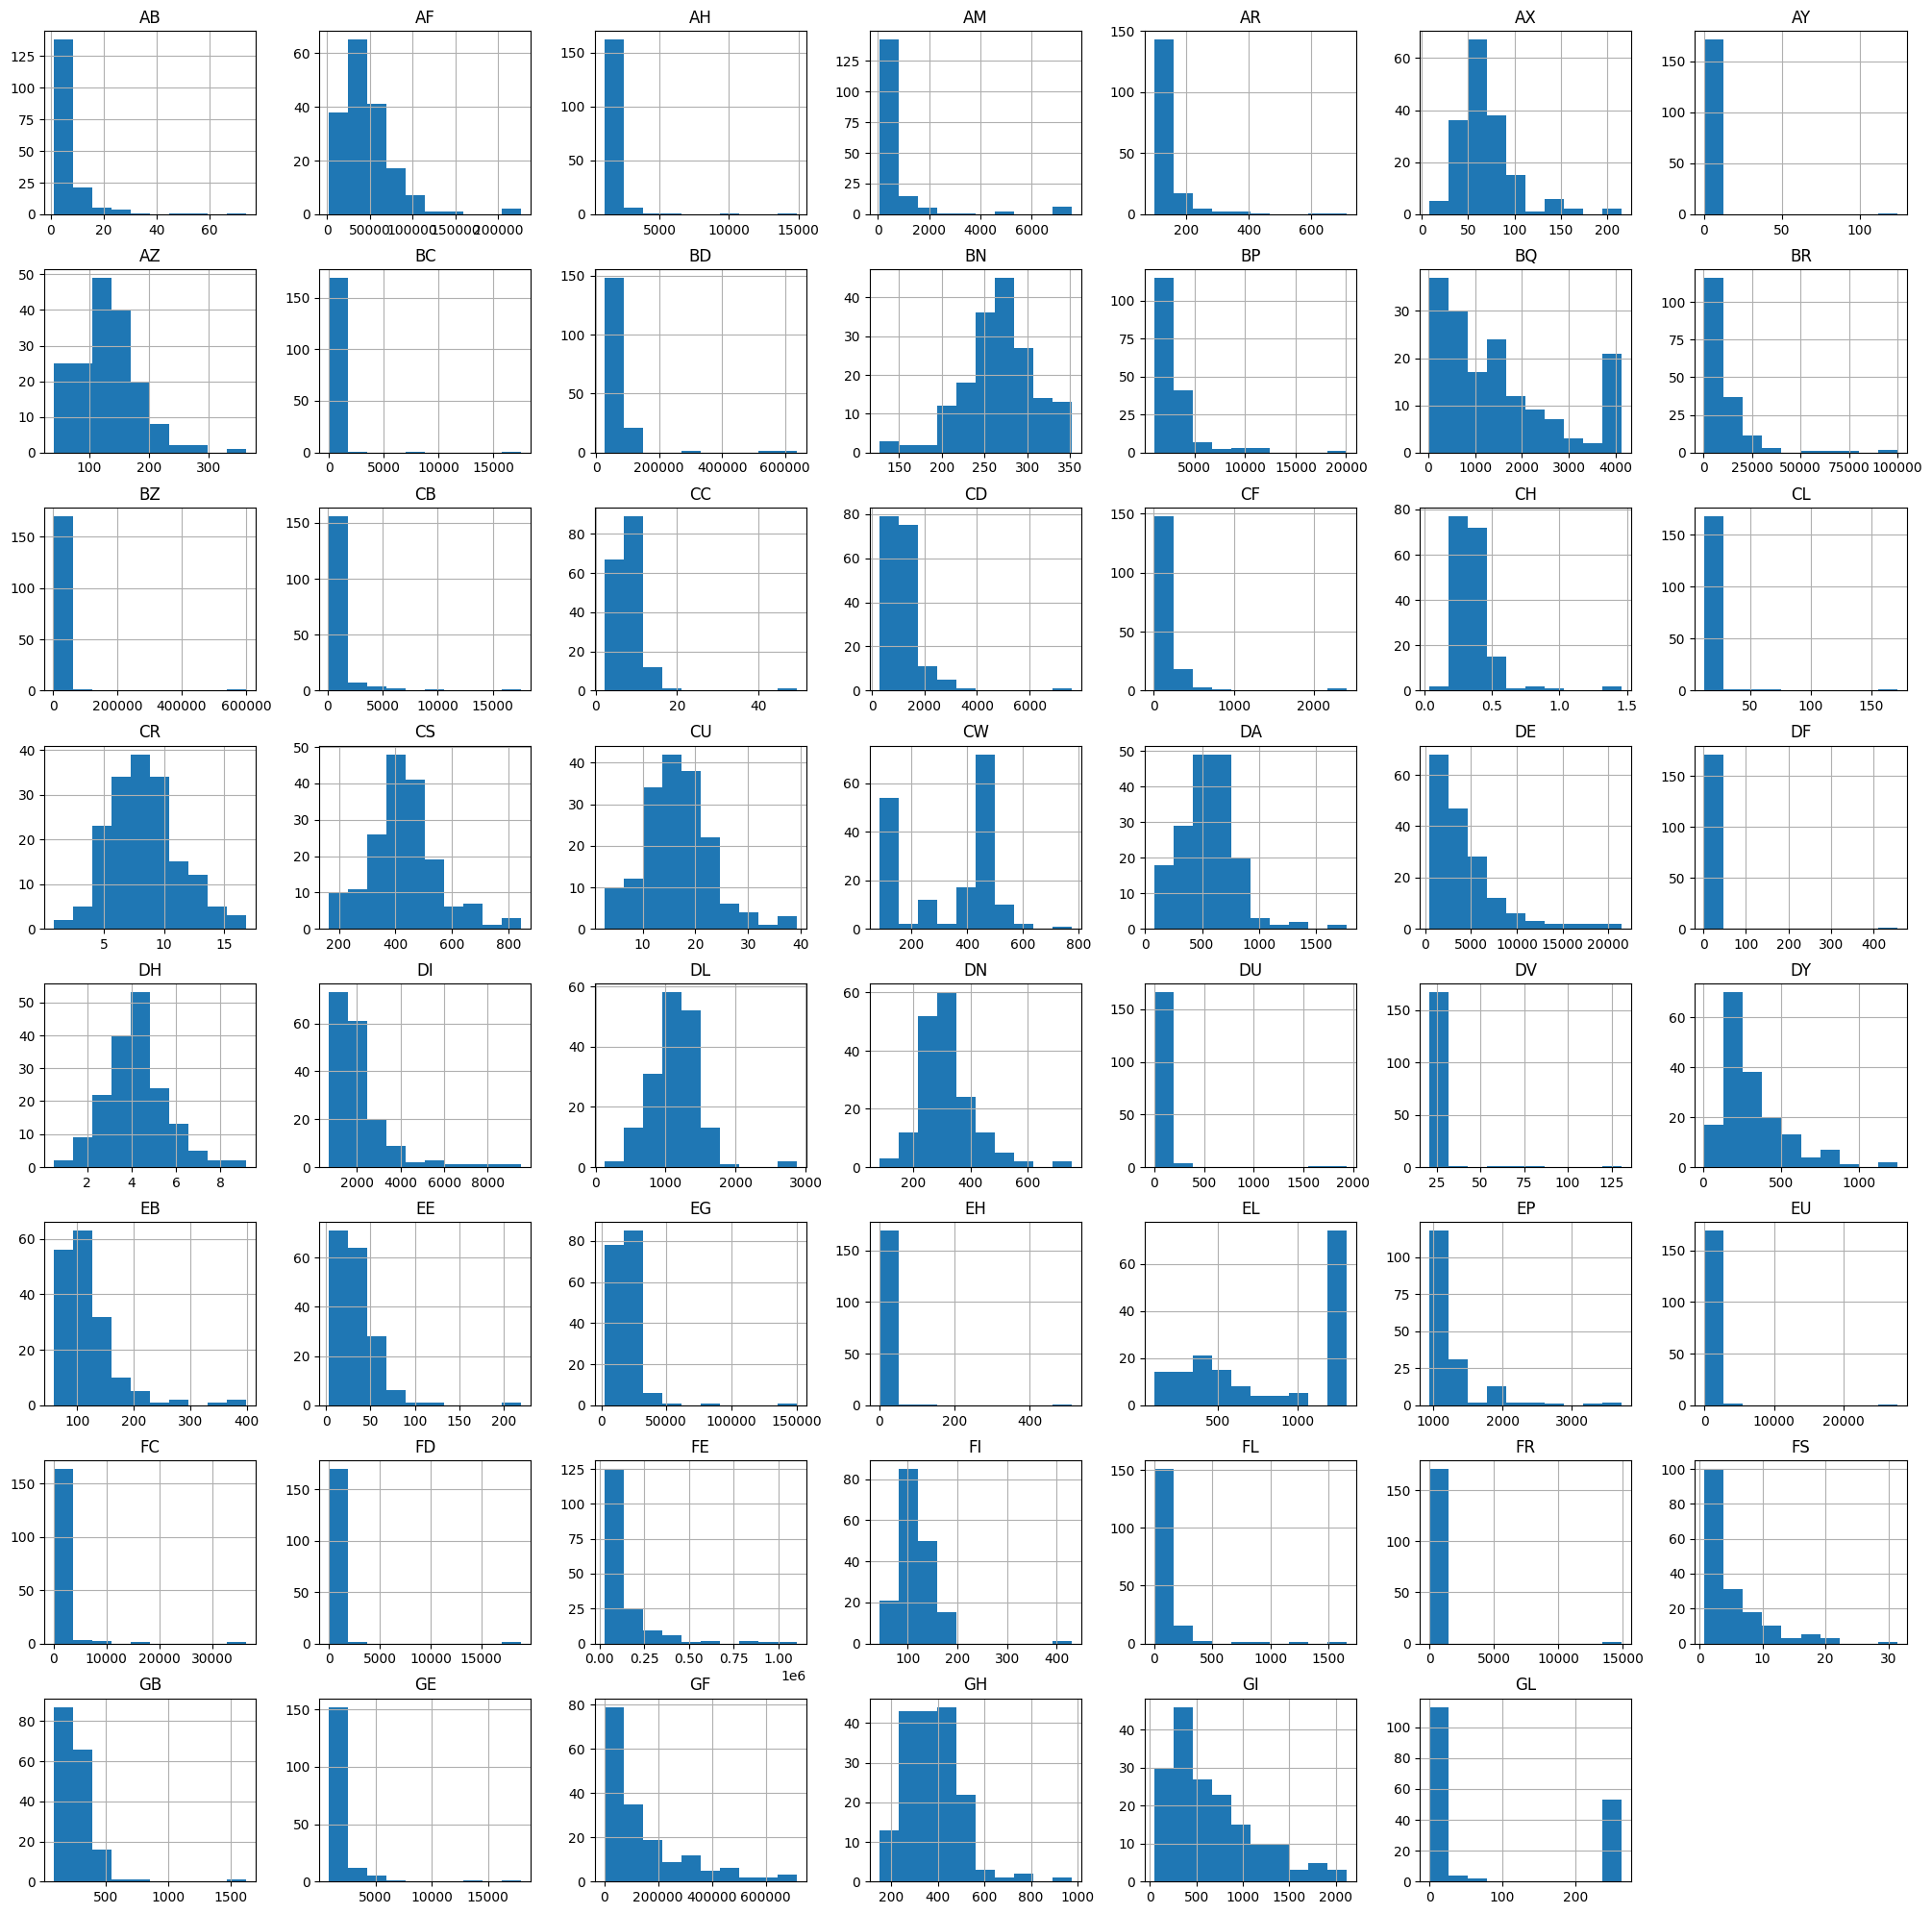

In [36]:
balanced_df.select_dtypes('float').hist(figsize=(25,25))
plt.show();

Checking for NaN: Numerical and replacing their values

In [37]:
balanced_df.select_dtypes('float').isnull().sum().sort_values(ascending=False)/len(df)*100

EL    2.636917
BQ    2.028398
CC    0.405680
FC    0.202840
FS    0.202840
CB    0.202840
DN    0.000000
DU    0.000000
DV    0.000000
DY    0.000000
EB    0.000000
EE    0.000000
EG    0.000000
EH    0.000000
EP    0.000000
EU    0.000000
AB    0.000000
DI    0.000000
FD    0.000000
FE    0.000000
FI    0.000000
FL    0.000000
FR    0.000000
GB    0.000000
GE    0.000000
GF    0.000000
GH    0.000000
GI    0.000000
DL    0.000000
DF    0.000000
DH    0.000000
BR    0.000000
AH    0.000000
AM    0.000000
AR    0.000000
AX    0.000000
AY    0.000000
AZ    0.000000
BC    0.000000
BD    0.000000
BN    0.000000
BP    0.000000
BZ    0.000000
AF    0.000000
CD    0.000000
CF    0.000000
CH    0.000000
CL    0.000000
CR    0.000000
CS    0.000000
CU    0.000000
CW    0.000000
DA    0.000000
DE    0.000000
GL    0.000000
dtype: float64

In [39]:
# Replaced with median, because distribution
for column in balanced_df.columns:
    balanced_df[column] = balanced_df[column].replace(np.nan,balanced_df[column].median())

In [40]:
balanced_df.select_dtypes('float').isnull().sum().sort_values(ascending=False)/len(df)*100

AB    0.0
EU    0.0
DL    0.0
DN    0.0
DU    0.0
DV    0.0
DY    0.0
EB    0.0
EE    0.0
EG    0.0
EH    0.0
EL    0.0
EP    0.0
FC    0.0
DH    0.0
FD    0.0
FE    0.0
FI    0.0
FL    0.0
FR    0.0
FS    0.0
GB    0.0
GE    0.0
GF    0.0
GH    0.0
GI    0.0
DI    0.0
DF    0.0
AF    0.0
BR    0.0
AH    0.0
AM    0.0
AR    0.0
AX    0.0
AY    0.0
AZ    0.0
BC    0.0
BD    0.0
BN    0.0
BP    0.0
BQ    0.0
BZ    0.0
DE    0.0
CB    0.0
CC    0.0
CD    0.0
CF    0.0
CH    0.0
CL    0.0
CR    0.0
CS    0.0
CU    0.0
CW    0.0
DA    0.0
GL    0.0
dtype: float64

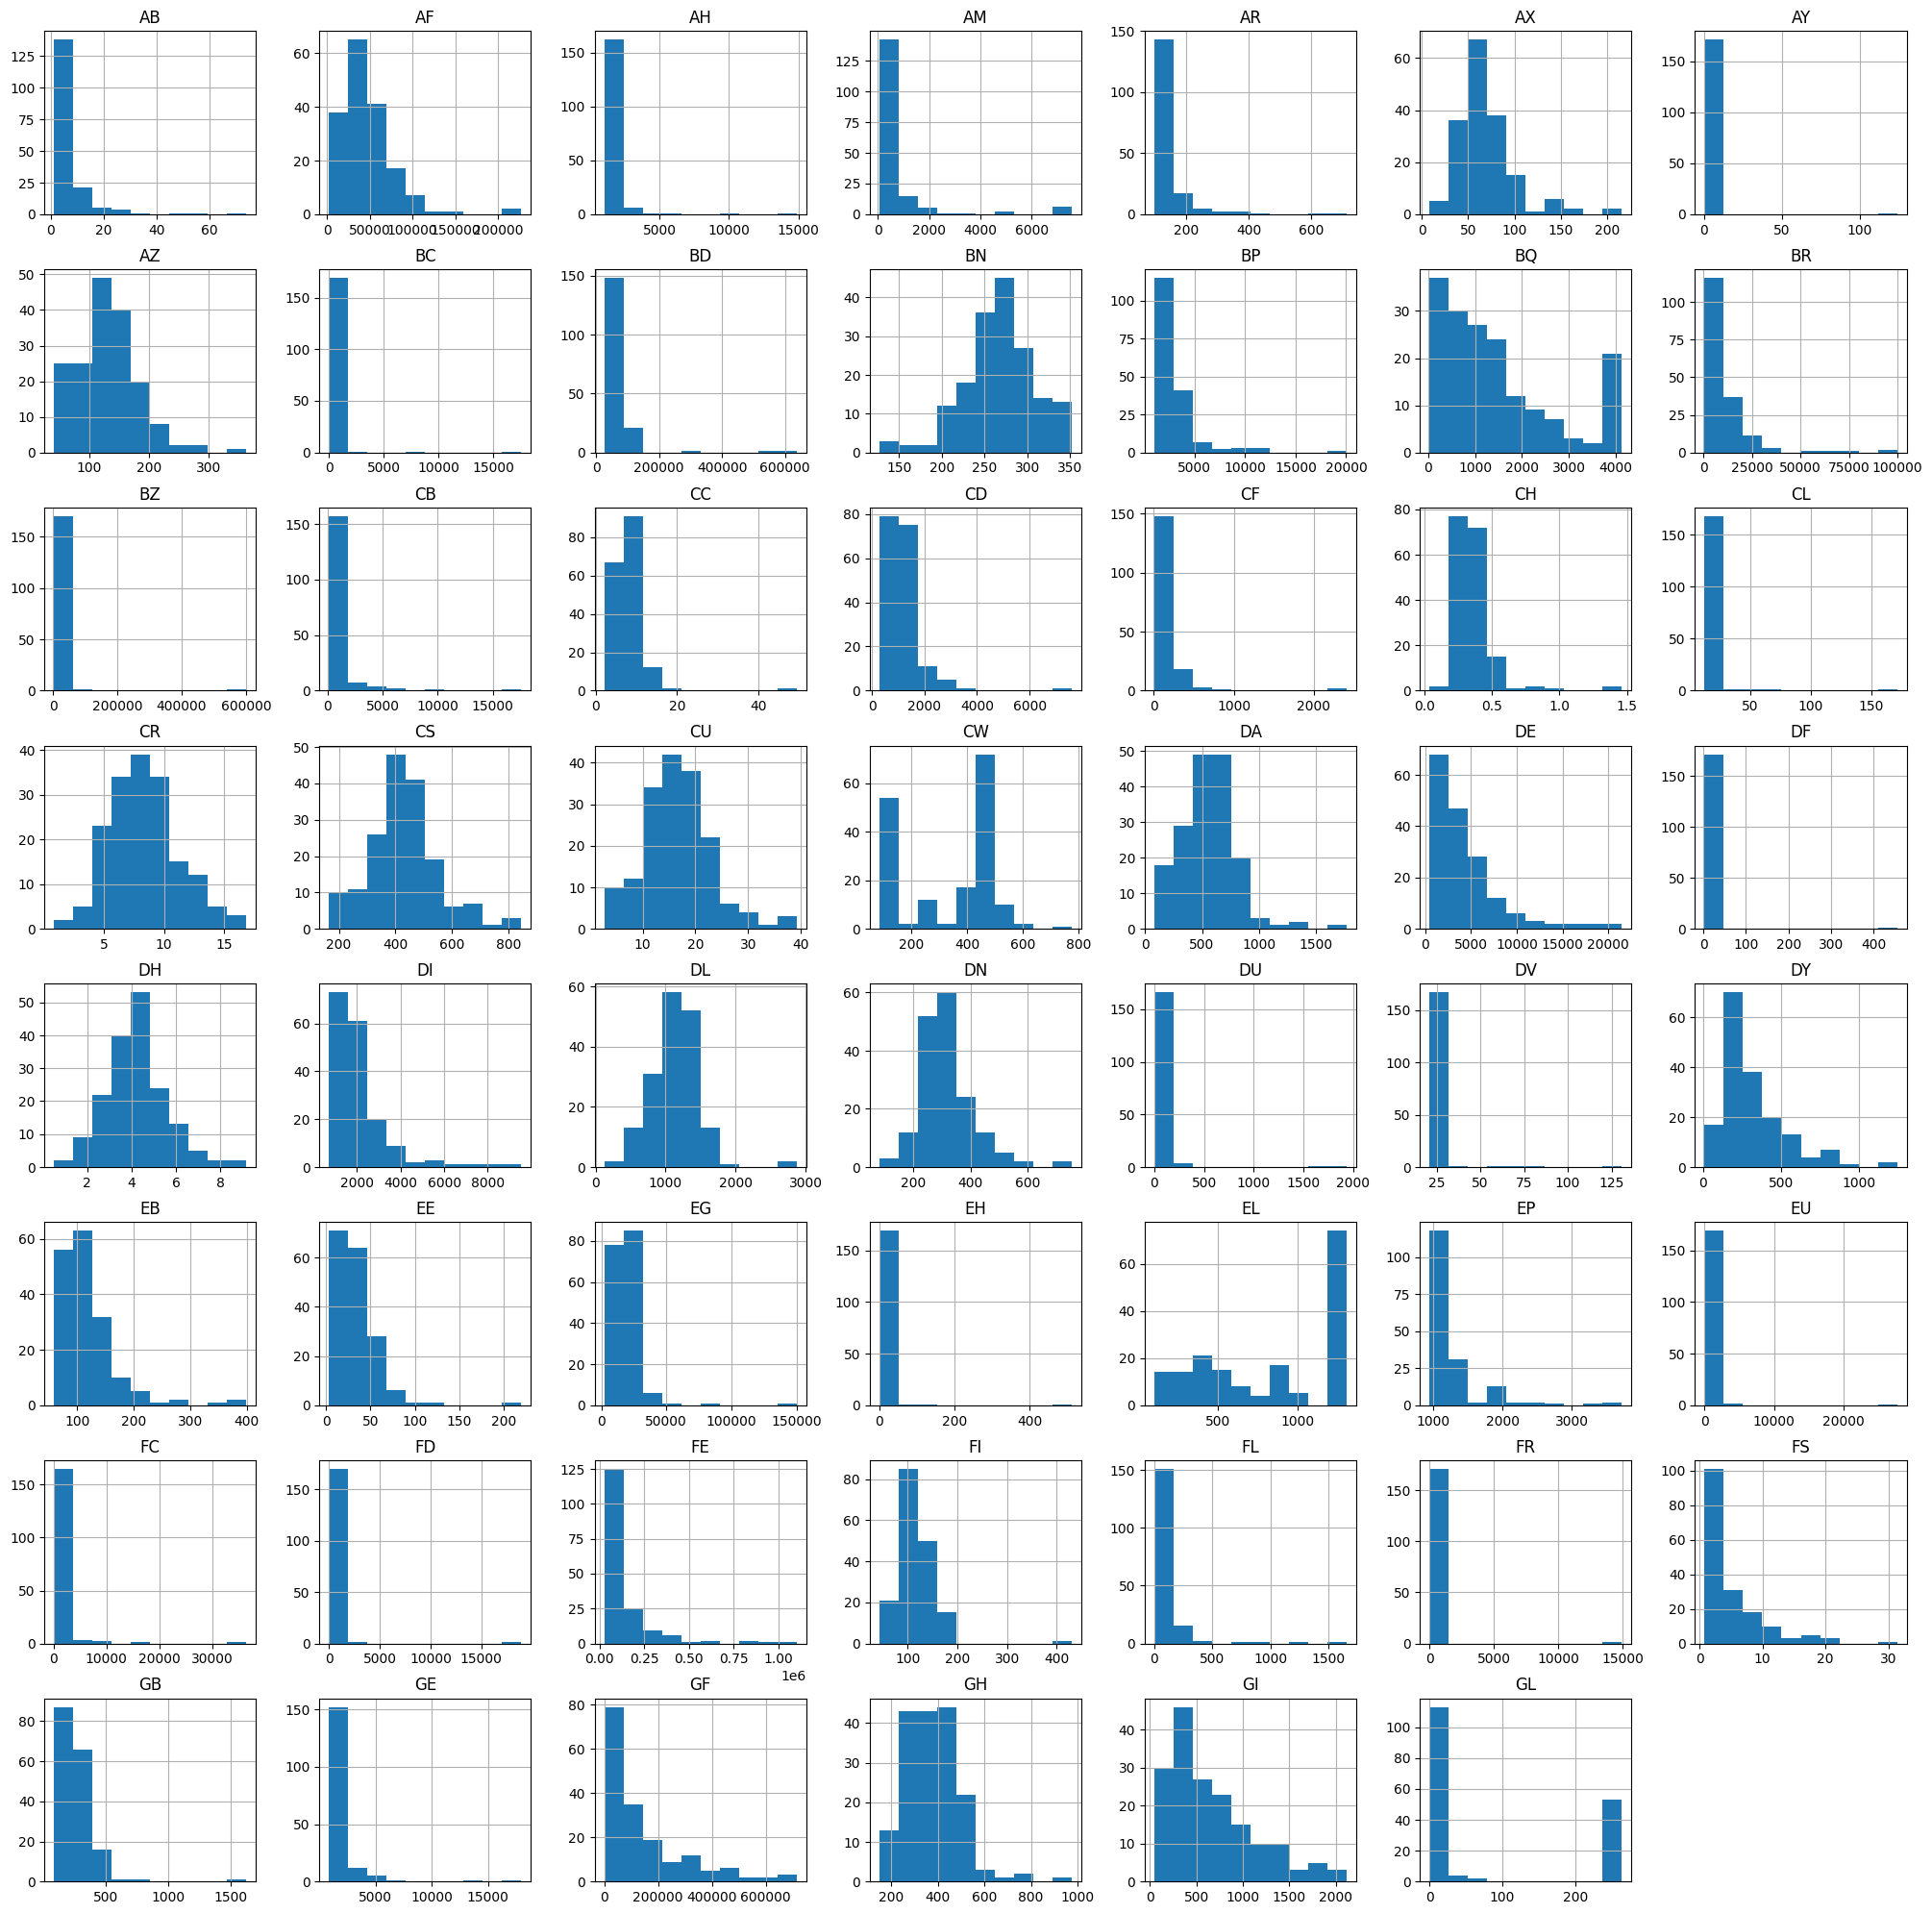

In [55]:
balanced_df.select_dtypes('float').hist(figsize=(25,25))
plt.show();

### Outliers

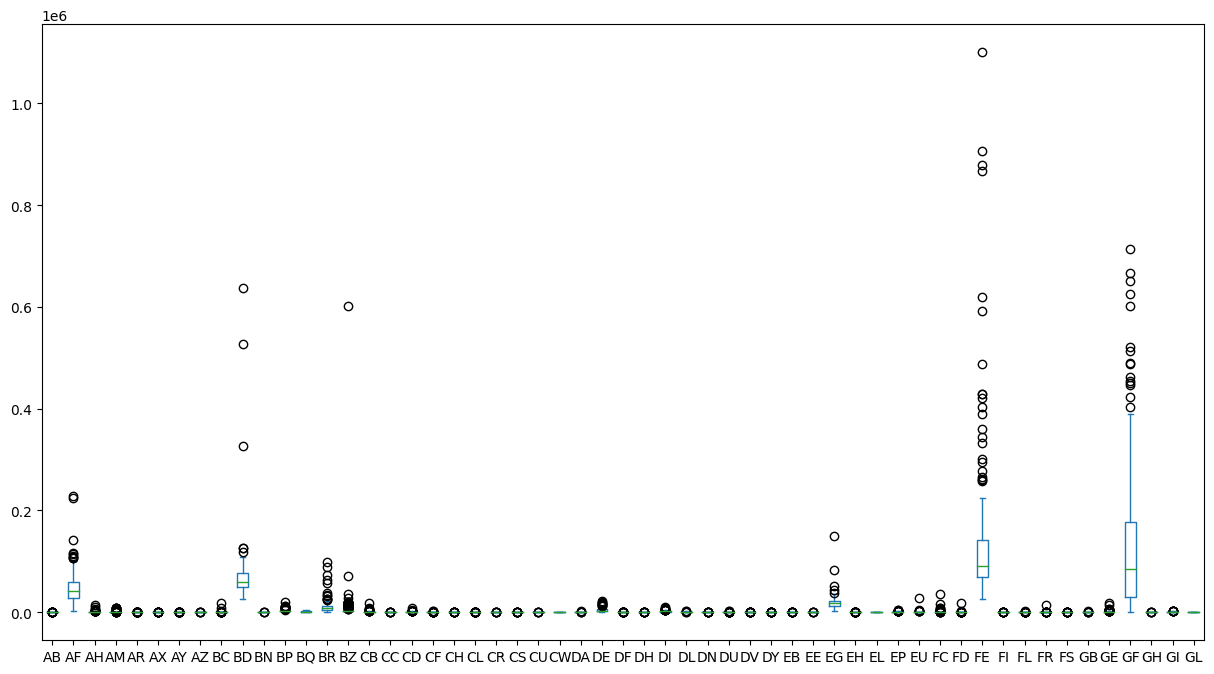

In [41]:
balanced_df.select_dtypes('float').plot(kind='box', figsize=(15,8))
plt.show();

__Summary__
- A few columns have outliers, as we do not know what the columns mean, we will still take them into consideration for now when we scale 
 - To do this, we will use a Robust scaler when scaling the numerical values

## Scaling [Robust] to consider Outliers

In [42]:
num_df = balanced_df.drop(columns=['EJ','Target'])

In [43]:
scaler=RobustScaler()
df_model = scaler.fit_transform(num_df)
df_model = pd.DataFrame(df_model)
df_model.columns = num_df.columns
df_model.reset_index(drop=True,inplace=True)

In [44]:
columns_dropped = ['EJ','Target']

In [45]:
balanced_df[columns_dropped].head()
balanced_df.reset_index(drop=True, inplace=True)

In [46]:
df_combined = pd.concat([df_model, balanced_df[columns_dropped]],axis=1)

df_combined.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Target
0,-0.414201,0.890804,0.000000,-0.148469,0.000000,-0.587399,0.0,-0.643866,-0.266423,-0.133503,...,-0.308943,-0.342857,0.859683,3.697841,-0.499977,1.287610,-0.144918,-0.003428,1,1
1,-0.473373,-0.309145,3.566574,-0.174380,5.543233,0.276646,0.0,0.559774,-0.266423,0.138753,...,-0.167495,-0.342857,-0.096085,0.000000,0.069200,0.548347,2.230044,0.000677,1,0


__Summary__
- All columns encoded - numerical now robust scaled
- New dataframe called 'df_combined'

<AxesSubplot:>

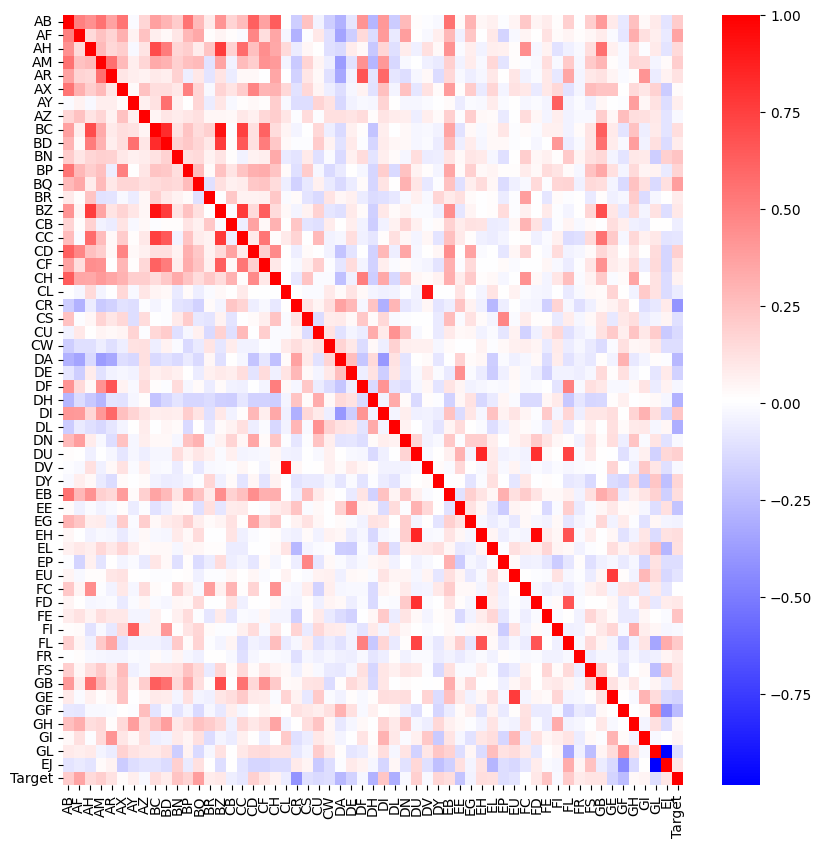

In [47]:
correlation_matrix = df_combined.corr()
column_names = correlation_matrix.columns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix,xticklabels=column_names,yticklabels=column_names,cmap= "bwr")

In [48]:
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*5)

,feature_1,feature_2,correlation,absolute_correlation
3189,EJ,GL,-0.983902,0.983902
3133,GL,EJ,-0.983902,0.983902
2209,EH,FD,0.974967,0.974967
2489,FD,EH,0.974967,0.974967
470,BC,BZ,0.927423,0.927423
806,BZ,BC,0.927423,0.927423
1173,CL,DV,0.907129,0.907129
1901,DV,CL,0.907129,0.907129
2198,EH,DU,0.849556,0.849556
1862,DU,EH,0.849556,0.849556


(-5.0, 20.0)

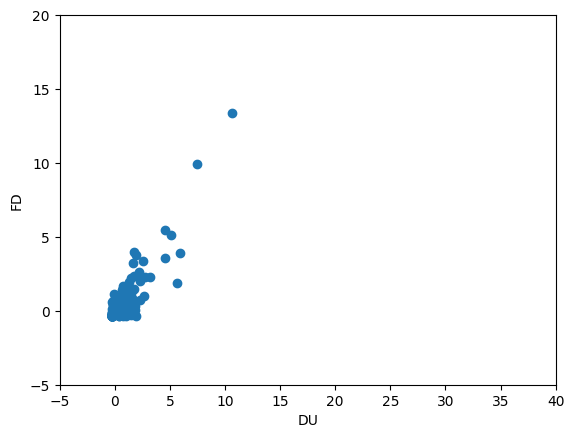

In [49]:
plt.scatter(x=df_combined['DU'], y=df_combined['FD'])
plt.xlabel('DU')
plt.ylabel('FD')
plt.xlim(-5,40)
plt.ylim(-5,20)

(-5.0, 5.0)

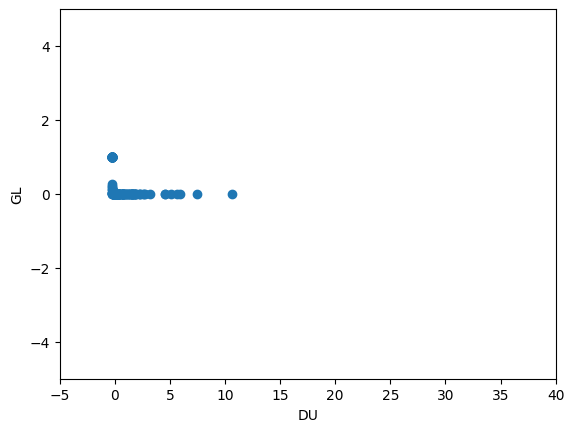

In [50]:
plt.scatter(x=df_combined['DU'], y=df_combined['GL'])
plt.xlabel('DU')
plt.ylabel('GL')
plt.xlim(-5,40)
plt.ylim(-5,5)

(-5.0, 20.0)

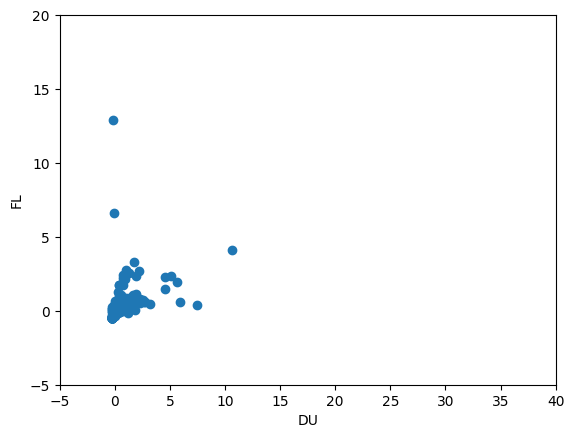

In [51]:
plt.scatter(x=df_combined['DU'], y=df_combined['FL'])
plt.xlabel('DU')
plt.ylabel('FL')
plt.xlim(-5,40)
plt.ylim(-5,20)

# Baseline Model

In [52]:
X = df_combined.drop(['Target'],axis=1)
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [53]:
def ml_models(X_train,X_test,y_train,y_test):

    models = [LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),RandomForestClassifier()]
    model_columns = []
    model_comparison = pd.DataFrame(columns=model_columns)
    row = 0

    for model in models:
        prediction = model.fit(X_train,y_train).predict(X_test)
        model_comparison.loc[row,'Model'] = model.__class__.__name__
        model_comparison.loc[row,'Accuracy'] = accuracy_score(y_test,prediction)
        model_comparison.loc[row,'Precision'] = precision_score(y_test,prediction,average='weighted')
        model_comparison.loc[row,'Recall'] = recall_score(y_test,prediction,average='weighted')
        model_comparison.loc[row,'F1 Score'] = f1_score(y_test,prediction,average='weighted')
        row += 1
    
    return model_comparison

In [54]:
ml_models(X_train,X_test,y_train,y_test)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.828571,0.847619,0.828571,0.826880
1,DecisionTreeClassifier,0.914286,0.915508,0.914286,0.914145
2,KNeighborsClassifier,0.714286,0.718045,0.714286,0.713819
3,RandomForestClassifier,0.885714,0.891165,0.885714,0.885528


## Model Tuning - LR

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
log_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [58]:
grid_log_reg = GridSearchCV(LogisticRegression(), log_params)

In [59]:
grid_log_reg.fit(X_train, y_train)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [60]:
grid_log_reg.best_estimator_

LogisticRegression(C=0.001)

In [61]:
grid_log_reg.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [62]:
del_LR = LogisticRegression(**grid_log_reg.best_params_)

In [63]:
model_columns = []
LR_postSearch = pd.DataFrame(columns=model_columns)

prediction = del_LR.fit(X_train,y_train).predict(X_test)
LR_postSearch.loc[0,'Model'] = 'LR post-GridSearch'
LR_postSearch.loc[0,'Accuracy'] = accuracy_score(y_test,prediction)
LR_postSearch.loc[0,'Precision'] = precision_score(y_test,prediction,average='weighted')
LR_postSearch.loc[0,'Recall'] = recall_score(y_test,prediction,average='weighted')
LR_postSearch.loc[0,'F1 Score'] = f1_score(y_test,prediction,average='weighted')

LR_postSearch

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1 Score
0,LR post-GridSearch,0.714286,0.724276,0.714286,0.709524


## Model Tuning - RFC

### Tuning parameters in model

Using RandomizedSearchCV

In [165]:
reg_rf = RandomForestClassifier()

In [166]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop=10000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 5, stop=30, num=4)]
min_samples_split = [5,10,15,100]

In [167]:
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split
}

In [168]:
rf_random = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, n_jobs=-1)

In [169]:
rf_random.fit(X_train, y_train)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 1200, 2300, 3400,
                                                         4500, 5600, 6700, 7800,
                                                         8900, 10000]})

In [170]:
rf_random.best_params_

{'n_estimators': 5600,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 30}

In [171]:
rf_random.best_score_

0.8760064412238325

Checking scores with best parameters

In [191]:
model_RFC = RandomForestClassifier(n_estimators=5600, min_samples_split=5,max_features='auto',max_depth=30)

In [192]:
model_columns = []
RFC_postSearch = pd.DataFrame(columns=model_columns)

prediction = del_RFC.fit(X_train,y_train).predict(X_test)
RFC_postSearch.loc[0,'Model'] = 'RFC post-RandomGrid'
RFC_postSearch.loc[0,'Accuracy'] = accuracy_score(y_test,prediction)
RFC_postSearch.loc[0,'Precision'] = precision_score(y_test,prediction,average='weighted')
RFC_postSearch.loc[0,'Recall'] = recall_score(y_test,prediction,average='weighted')
RFC_postSearch.loc[0,'F1 Score'] = f1_score(y_test,prediction,average='weighted')

RFC_postSearch

NameError: name 'del_RFC' is not defined

Confusion matrix: Data unbalance needs to be fixed

In [175]:
matrix = confusion_matrix(y_test, prediction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

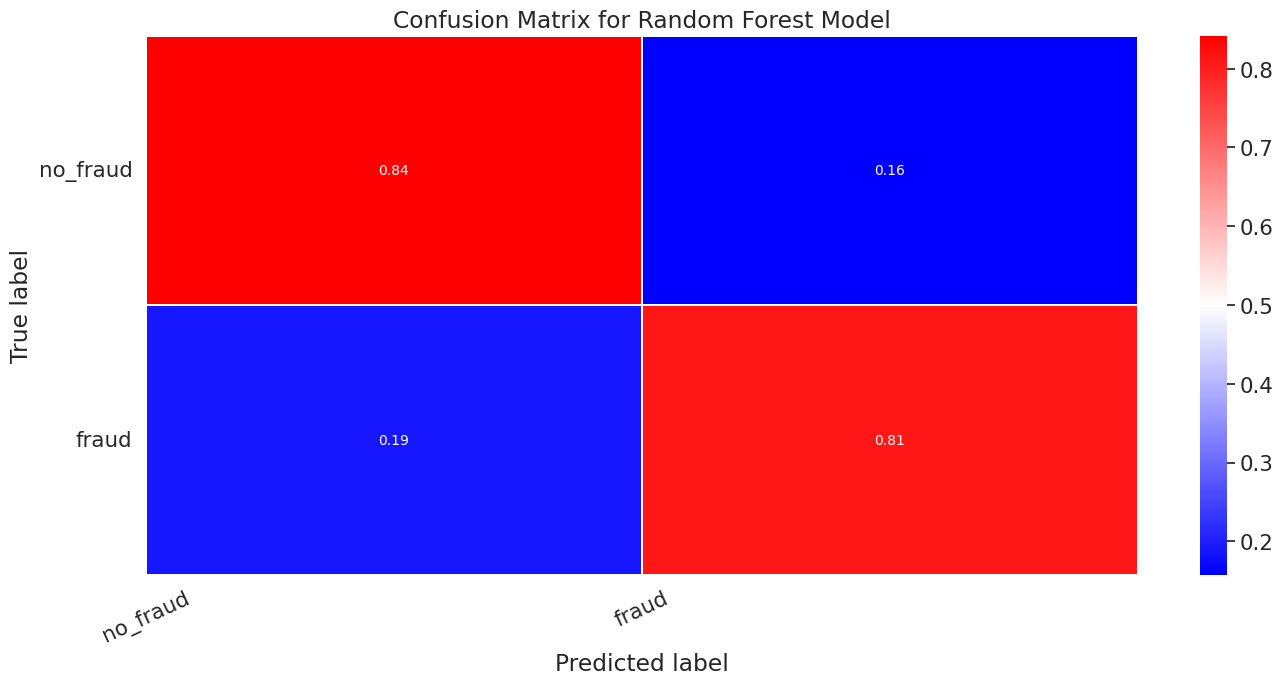

In [176]:

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap='bwr', linewidths=0.2)

class_names = ['no_fraud','fraud']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## SMOTE - Oversampling

# Feature Selection

In [52]:
feat_dict = {}

for col, val in sorted(zip(X_train.columns, model_RFC.feature_importances_),
                       key=lambda x:x[1],reverse=True):
    feat_dict[col] = val

In [53]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),
                        'Importance':feat_dict.values()})
feat_df.head(10)

,Feature,Importance
0,DU,0.118662
1,FL,0.059799
2,GL,0.057578
3,EH,0.045309
4,DA,0.042575
5,FD,0.037767
6,CR,0.035233
7,BC,0.034020
8,DI,0.029875
9,BQ,0.028958


In [54]:
X = df_combined[['DU', 'GL','FL','FR','EH']]
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

RFC_feat = ml_models(X_train, X_test, y_train, y_test)
RFC_feat

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.868687,0.821090,0.868687,0.839274
1,DecisionTreeClassifier,0.787879,0.770418,0.787879,0.778280
2,KNeighborsClassifier,0.838384,0.801768,0.838384,0.816488
3,RandomForestClassifier,0.808081,0.781343,0.808081,0.794472


Trying another method...

In [55]:
top5_features = SelectKBest(score_func=mutual_info_classif,k='all')
fit= top5_features.fit(X,y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)
featureScores = pd.concat([columns,scores],axis=1)
featureScores.columns = ['Feature','Score']

featureScores.nlargest(10,'Score')

,Feature,Score
0,DU,0.160817
1,GL,0.146915
2,FL,0.135622
4,EH,0.119509
3,FR,0.074360


In [56]:
X = df_combined[['DU', 'GL','FL','EH','FD']]
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Feature = ml_models(X_train, X_test, y_train, y_test)
Feature

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Unde

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.818182,0.724393,0.818182,0.767141
1,DecisionTreeClassifier,0.797980,0.736925,0.797980,0.765171
2,KNeighborsClassifier,0.828283,0.745310,0.828283,0.784601
3,RandomForestClassifier,0.838384,0.751647,0.838384,0.792523


# Not a Pipeline 😔

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [57]:
def object_clean(df):

    df = df.rename(columns=lambda x: x.strip())
    
    df['EJ'] = df['EJ'].map({'A':0, 'B':1})

    df.drop('Id',axis=1,inplace=True)

    return df

In [58]:
def num_clean(df):

    # for raw test
    num_df = df.drop(columns=['EJ'])
    columns_dropped = ['EJ']
    NaN_columns = ['BQ','EL','FS']

    # Replaced with median, because distribution
    for column in NaN_columns:
        num_df[column] = num_df[column].replace(np.nan,num_df[column].median())
    
    scaler = RobustScaler()

    df_model = scaler.fit_transform(num_df)
    df_model = pd.DataFrame(df_model)
    df_model.columns = num_df.columns

    df_combined = pd.concat([df_model, df[columns_dropped]],axis=1)

    return df_combined

In [59]:
def predict(ml_model):
    model = ml_model.fit(X_train, y_train)
    print(f'Training score: {model.score(X_train, y_train)}')

    y_prediction = model.predict(X_test)
    print(f'Predictions are: {y_prediction}\n')
    
    r2_score = metrics.r2_score(y_test, y_prediction)
    print(f'r2 score: {r2_score}')
    print(f'MAE: {metrics.mean_absolute_error(y_test, y_prediction)}')
    print(f'MSE: {metrics.mean_squared_error(y_test, y_prediction)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_prediction))}')
    print(f'MAPE: {mape(y_test, y_prediction)}')
    sns.displot(y_test-y_prediction)

# Evaluation

In [60]:
test_df = pd.read_csv('raw_data/testset_.csv')

In [61]:
test_df = object_clean(test_df)

In [62]:
test_df = num_clean(test_df)
test_df.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ
0,-0.279221,-1.778508,0.000000,1.181749,155.243376,-0.490751,5.682243,0.629591,2.352379,0.301694,...,-0.522496,0.436220,-0.418301,1.371979,0.0,7.920907,0.031090,-0.534308,0.991716,0
1,0.876623,0.513209,1.495802,0.683226,100.873584,0.843308,0.000000,0.593889,0.812264,-0.403146,...,-0.522496,-0.579821,1.424837,-0.351586,0.0,0.387373,-0.079825,0.336813,0.991716,0


Reloading model and train data

In [63]:
X = df_combined.drop(['Target'],axis=1)
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [65]:
model_RFC = RandomForestClassifier(n_estimators=6700, min_samples_split=5,max_features='sqrt',max_depth=30)

In [66]:
model_RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=6700)

In [67]:
model_RFC.predict(test_df)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Model Extra (out of curiosity)

In [73]:
def object_clean_binary(df):

    df = df.rename(columns=lambda x: x.strip())
    
    df['Target'] = df['Target'].map({'no_fraud':0,
                  'payment_fraud':1,
                  'identification_fraud':1,
                  'malware_fraud':1})
    
    df['EJ'] = df['EJ'].map({'A':0, 'B':1})

    df.drop('Id',axis=1,inplace=True)

    return df

In [74]:
def num_clean_binary(df):

    # for fraud or no fraud
    num_df = df.drop(columns=['EJ','Target'])
    columns_dropped = ['EJ', 'Target']
    NaN_columns = ['EL','BQ','CC','CB','GL','FL','DU','FC','FS']

    # Replaced with median, because distribution
    for column in NaN_columns:
        num_df[column] = num_df[column].replace(np.nan,num_df[column].median())
    
    scaler = RobustScaler()

    df_model = scaler.fit_transform(num_df)
    df_model = pd.DataFrame(df_model)
    df_model.columns = num_df.columns

    df_combined = pd.concat([df_model, df[columns_dropped]],axis=1)

    return df_combined

In [75]:
train_data = pd.read_csv('raw_data/trainset_.csv')
train_data = object_clean_binary(train_data)
train_data = num_clean_binary(train_data)
train_data.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Target
0,-0.441176,-1.284050,4.980837,-0.479326,52.733664,2.086466,2.857143,0.495507,0.956947,-0.702600,...,-0.393887,0.261194,-0.201462,9.14344,0.296894,-0.404405,2.572202,0.989770,0,0
1,1.397059,-0.051925,0.000000,-0.214138,0.000000,-0.582707,0.000000,-0.111682,0.000000,-1.230881,...,0.917820,-0.246269,-0.570268,0.00000,-0.100522,-0.467115,-0.446272,-0.011313,1,0


In [76]:
train_data['Target'].value_counts()

0    407
1     86
Name: Target, dtype: int64

In [ ]:
X = train_data.drop(['Target'],axis=1)
y = train_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
def ml_models(X_train,X_test,y_train,y_test):

    models = [LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),RandomForestClassifier()]
    model_columns = []
    model_comparison = pd.DataFrame(columns=model_columns)
    row = 0

    for model in models:
        prediction = model.fit(X_train,y_train).predict(X_test)
        model_comparison.loc[row,'Model'] = model.__class__.__name__
        model_comparison.loc[row,'Accuracy'] = accuracy_score(y_test,prediction)
        model_comparison.loc[row,'Precision'] = precision_score(y_test,prediction,average='weighted')
        model_comparison.loc[row,'Recall'] = recall_score(y_test,prediction,average='weighted')
        model_comparison.loc[row,'F1 Score'] = f1_score(y_test,prediction,average='weighted')
        row += 1
    
    return model_comparison

In [ ]:
ml_models(X_train,X_test,y_train,y_test)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.848485,0.828941,0.848485,0.831945
1,DecisionTreeClassifier,0.838384,0.824434,0.838384,0.829533
2,KNeighborsClassifier,0.828283,0.783360,0.828283,0.781438
3,RandomForestClassifier,0.888889,0.887515,0.888889,0.871779


In [ ]:
xtra_rf  = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, n_jobs=-1)

In [ ]:
xtra_rf.fit(X_train,y_train)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 1200, 2300, 3400,
                                                         4500, 5600, 6700, 7800,
                                                         8900, 10000]})

In [ ]:
xtra_rf.best_params_

{'n_estimators': 6700,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 21}

In [ ]:
xtra_rf.best_score_

0.8884069704680391

In [ ]:
simple_RFC = RandomForestClassifier(n_estimators=6700, min_samples_split=5,max_features='auto',max_depth=21)

In [ ]:
model_columns = []
RFC_postSearch = pd.DataFrame(columns=model_columns)

prediction = simple_RFC.fit(X_train,y_train).predict(X_test)
RFC_postSearch.loc[0,'Model'] = 'RFC post-RandomGrid'
RFC_postSearch.loc[0,'Accuracy'] = accuracy_score(y_test,prediction)
RFC_postSearch.loc[0,'Precision'] = precision_score(y_test,prediction,average='weighted')
RFC_postSearch.loc[0,'Recall'] = recall_score(y_test,prediction,average='weighted')
RFC_postSearch.loc[0,'F1 Score'] = f1_score(y_test,prediction,average='weighted')

RFC_postSearch

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,Model,Accuracy,Precision,Recall,F1 Score
0,RFC post-RandomGrid,0.888889,0.881898,0.888889,0.87676


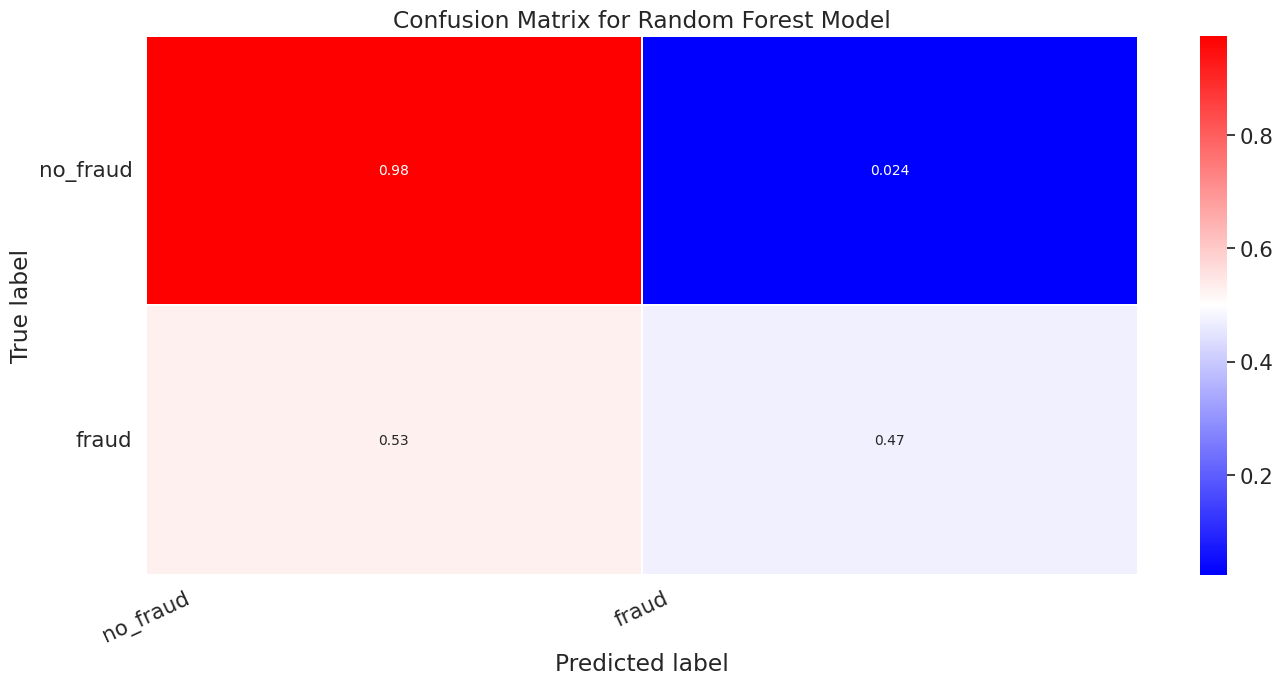

In [ ]:
matrix = confusion_matrix(y_test, prediction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap='bwr', linewidths=0.2)

class_names = ['no_fraud','fraud']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Evaluation: Round 2 (out of curiosity)

In [ ]:
train_data = pd.read_csv('raw_data/trainset_.csv')
train_data = object_clean(train_data)
train_data = num_clean(train_data)
train_data.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Target
0,-0.441176,-1.284050,4.980837,-0.479326,52.733664,2.086466,2.857143,0.495507,0.956947,-0.702600,...,-0.393887,0.261194,-0.201462,9.14344,0.296894,-0.404405,2.572202,0.989770,0,0
1,1.397059,-0.051925,0.000000,-0.214138,0.000000,-0.582707,0.000000,-0.111682,0.000000,-1.230881,...,0.917820,-0.246269,-0.570268,0.00000,-0.100522,-0.467115,-0.446272,-0.011313,1,0


In [ ]:
X = train_data.drop(['Target'],axis=1)
y = train_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
reg_rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, n_jobs=-1)

In [ ]:
rf_random.fit(X_train, y_train)

/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mai/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 1200, 2300, 3400,
                                                         4500, 5600, 6700, 7800,
                                                         8900, 10000]})

In [ ]:
rf_random.best_params_

{'n_estimators': 5600,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 30}

In [ ]:
rf_random.best_score_

0.9130434782608696

In [ ]:
simple_RFC = RandomForestClassifier(n_estimators=5600, min_samples_split=5,max_features='sqrt',max_depth=30)

In [ ]:
simple_RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=5600)

In [ ]:
test_pred = simple_RFC.predict(test_df)